In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

from functools import partial
import torch.nn as nn
from torch.autograd import grad
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm


In [3]:
torch.__version__

'2.1.0'

In [4]:
def set_device():
    device = 'cpu'
    if torch.cuda.device_count() > 0 and torch.cuda.is_available():
        print("Cuda installed! Running on GPU!")
        device = torch.device(torch.cuda.current_device())
        print(f'Device: {device} {torch.cuda.get_device_name(device)}')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f'Device: {device} {(device)}')
    else:
        print("No GPU available!")
    return device
    

In [5]:
device = set_device()
device

Device: mps mps


device(type='mps')

In [6]:
#Loading the data
data = scipy.io.loadmat('burgers_shock.mat')  

In [7]:

nu = 0.01/np.pi
N_u = 2000 
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

######################################################################
######################## Noiseles Data ###############################
######################################################################
noise = 0.0            
         
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
x_train = X_star[idx,:]
u_train = u_star[idx,:]
noise = 0.01
u_train_noise = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
print(X_star.shape, u_star.shape)

(25600, 2) (25600, 1)


In [8]:
Exact.shape

(100, 256)

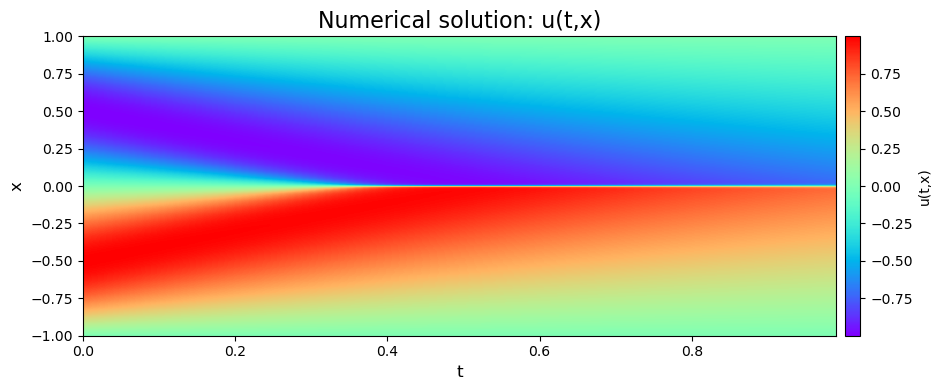

In [9]:
# Creating plot for numerical solution
fig, ax = plt.subplots(1, figsize=(10,4))
im = ax.imshow(Exact.T,  cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('u(t,x)')

plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Numerical solution: u(t,x)', fontsize = 16)
plt.tight_layout()
plt.show()

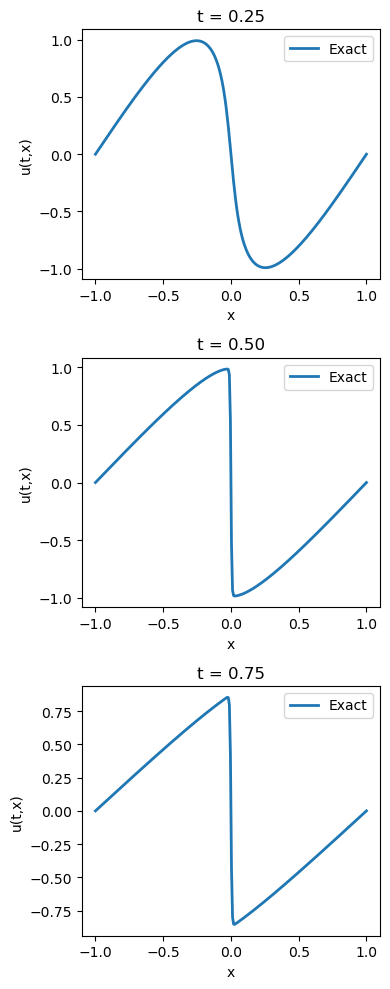

In [10]:
# Creating plot for numerical solution
fig, ax = plt.subplots(3,1, figsize=(4,10))
ax[0].plot(x,Exact[25,:], linewidth = 2, label = 'Exact')
ax[0].set(title = 't = 0.25', xlabel = 'x', ylabel = 'u(t,x)')
ax[1].plot(x,Exact[50,:], linewidth = 2, label = 'Exact') 
ax[1].set(title = 't = 0.50', xlabel = 'x', ylabel = 'u(t,x)')
ax[2].plot(x,Exact[75,:], linewidth = 2, label = 'Exact') 
ax[2].set(title = 't = 0.75', xlabel = 'x', ylabel = 'u(t,x)')
plt.tight_layout()
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [11]:
x_train.shape

(2000, 2)

In [12]:

x_train = torch.from_numpy(x_train)
x_train = x_train.to(torch.float32)
x_train.requires_grad = True

u_train = torch.from_numpy(u_train)
u_train = u_train.to(torch.float32)
u_train.requires_grad = True

u_train_noise = torch.from_numpy(u_train_noise)
u_train_noise = u_train_noise.to(torch.float32)
u_train_noise.requires_grad = True


x_train = x_train.to(device)
u_train = u_train.to(device)
u_train_noise = u_train_noise.to(device)

In [13]:
x_train.device, u_train.device, x_train.dtype, u_train.dtype, x_train.shape, u_train.shape

(device(type='mps', index=0),
 device(type='mps', index=0),
 torch.float32,
 torch.float32,
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

In [14]:
class FCNI(nn.Module): # Forward


    def __init__(self, n_input = 1, n_nodes = 5, n_hl = 3, n_output = 1, act = "tanh"):

        super(FCNI, self).__init__()

        if act == "tanh":
            layers = [nn.Linear(n_input, n_nodes), nn.Tanh()]
            for _ in range(n_hl - 1):
                layers.append(nn.Linear(n_nodes, n_nodes))
                layers.append(nn.Tanh())
            layers.append(nn.Linear(n_nodes, n_output))
        elif act == "gelu":
            layers = [nn.Linear(n_input, n_nodes), nn.GELU()]
            for _ in range(n_hl - 1):
                layers.append(nn.Linear(n_nodes, n_nodes))
                layers.append(nn.GELU())
            layers.append(nn.Linear(n_nodes, n_output))
        else:
            layers = [nn.Linear(n_input, n_nodes), nn.ReLU()]
            for _ in range(n_hl - 1):
                layers.append(nn.Linear(n_nodes, n_nodes))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(n_nodes, n_output))

        self.layers = nn.Sequential(*layers)
        self.lambda_1 = nn.Parameter(torch.tensor([0.0], requires_grad = True))
        self.lambda_2 = nn.Parameter(torch.tensor([-6.0], requires_grad = True))

    def forward(self, x):
        return self.layers(x)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

model_i = FCNI(n_input = 2, n_nodes = 20, n_hl = 9, n_output = 1, act = 'tanh')
model_i.apply(init_weights)
model_i.to(device)

opt = torch.optim.Adam(model_i.parameters(), lr = 1e-3)
iter = 0
model_i

FCNI(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [15]:
x_train.shape

torch.Size([2000, 2])

In [16]:
def compute_partials(model, X):

    x = torch.squeeze(X[:, 0])
    t = torch.squeeze(X[:, 1])
    d_train = torch.concat((x.view(-1, 1), t.view(-1,1)), axis = 1)
    d_train = torch.unsqueeze(d_train, 0)
    u_pred = model(d_train)
    u_pred = torch.squeeze(u_pred)

    u_t = grad(u_pred, t, torch.ones_like(t), create_graph = True)[0]
    u_x = grad(u_pred, x, torch.ones_like(x), create_graph = True)[0]
    u_xx = grad(u_x, x, torch.ones_like(x), create_graph = True)[0]
    f = u_t + model.lambda_1*u_pred*u_x - torch.exp(model.lambda_2)*u_xx
    #returning as column tensors
    return f.view(-1, 1), u_pred.view(-1,1)


def loss_complete(model, X, u):

    f, u_pred = compute_partials(model, X)
    l1 = torch.mean((u - u_pred)**2)
    l2 = torch.mean((f)**2)
    
    loss = l1 + l2
    return loss


def tr_step(model, opt, X, u_ori, lrlambdas = 1e-3):


    opt.zero_grad()

    l = loss_complete(model, X, u_ori)
    l.backward()
    model.lambda_1.data.sub_(lrlambdas * model.lambda_1.grad)
    model.lambda_2.data.sub_(lrlambdas * model.lambda_2.grad)
    model.lambda_1.grad.zero_()
    model.lambda_2.grad.zero_()

    opt.step()

    return l.cpu().detach().numpy()

def closure(model, opt, X, u_ori, lrlambdas = 3e-3):
    """
    The closure function to use L-BFGS optimization method.
    """
    opt.zero_grad()
    # evaluating the MSE for the PDE
    loss = loss_complete(model, X, u_ori)
    loss.backward()
    # model.lambda_1.data.sub_(lrlambdas * model.lambda_1.grad)
    # model.lambda_2.data.sub_(lrlambdas * model.lambda_2.grad)
    # model.lambda_1.grad.zero_()
    # model.lambda_2.grad.zero_()

    tr_loss.append(loss.cpu().detach().numpy())
    global iter
    iter += 1
    if iter % 20 == 0:
        print(f"iteration: {iter}  loss: {loss.item():.6f}")
        print(f"lambda1 = {1.00}   || lambda_hat_1 = {model.lambda_1.item():.6f}")
        print(f"lambda2 = {-0.0031831}   || lambda_hat_2 = {torch.exp(model.lambda_2).item():.6f}")

    if iter % 30==0:
        torch.save(model.state_dict(), f'models_trained/model_LBFGS_{iter}.pt')
    return loss

def tr_lbfgs(model, X, u_ori):
    # Initialize the optimizer
    ls = [None, "strong_wolfe"]
    optimizer = torch.optim.LBFGS(model.parameters(),
                                  lr = 1,
                                  max_iter = 50000,
                                  max_eval = 50000,
                                  history_size = 50,
                                  tolerance_grad = 1e-06,
                                  tolerance_change = 1 * np.finfo(float).eps,
                                  line_search_fn = ls[1])

    # the optimizer.step requires the closure function to be a callable function without inputs
    # therefore we need to define a partial function and pass it to the optimizer
    closure_fn = partial(closure, model, optimizer, X, u_ori)
    optimizer.step(closure_fn)


In [17]:
# training loop -- Adam
epochs = 10000
tr_loss = []
for epoch in tqdm(range(epochs)):
    l = tr_step(model_i, opt, x_train, u_train) 
    tr_loss.append(l)
    if epoch % 10 == 0:
        print(f"Training Loss at epoch {epoch + 1}: {tr_loss[-1]:.6f}")
    if epoch % 20 == 0:
        print(f"lambda1 = {1.}     || lambda_hat_1 = {model_i.lambda_1.item():.6f}")
        print(f"lambda2 = {-0.0031831}   || lambda_hat_2 = {torch.exp(model_i.lambda_2).item():.6f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Training Loss at epoch 1: 0.423571
lambda1 = 1.0     || lambda_hat_1 = -0.000000
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 11: 0.240012
Training Loss at epoch 21: 0.206038
lambda1 = 1.0     || lambda_hat_1 = -0.000668
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 31: 0.172341
Training Loss at epoch 41: 0.128298
lambda1 = 1.0     || lambda_hat_1 = -0.000817
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 51: 0.094048
Training Loss at epoch 61: 0.074509
lambda1 = 1.0     || lambda_hat_1 = -0.000539
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 71: 0.063711
Training Loss at epoch 81: 0.055344
lambda1 = 1.0     || lambda_hat_1 = 0.001415
lambda2 = -0.0031831   || lambda_hat_2 = 0.002478
Training Loss at epoch 91: 0.047688
Training Loss at epoch 101: 0.042178
lambda1 = 1.0     || lambda_hat_1 = 0.003554
lambda2 = -0.0031831   || lambda_hat_2 = 0.002478
Training Loss at epoch 111: 0.

In [25]:
tr_lbfgs(model_i, x_train, u_train)

iteration: 40  loss: 0.005526
lambda1 = 1.0   || lambda_hat_1 = 0.595172
lambda2 = -0.0031831   || lambda_hat_2 = 0.002562
iteration: 60  loss: 0.004441
lambda1 = 1.0   || lambda_hat_1 = 0.642858
lambda2 = -0.0031831   || lambda_hat_2 = 0.002717
iteration: 80  loss: 0.003218
lambda1 = 1.0   || lambda_hat_1 = 0.780051
lambda2 = -0.0031831   || lambda_hat_2 = 0.002919
iteration: 100  loss: 0.002560
lambda1 = 1.0   || lambda_hat_1 = 0.818484
lambda2 = -0.0031831   || lambda_hat_2 = 0.003033
iteration: 120  loss: 0.002247
lambda1 = 1.0   || lambda_hat_1 = 0.837290
lambda2 = -0.0031831   || lambda_hat_2 = 0.003080
iteration: 140  loss: 0.002022
lambda1 = 1.0   || lambda_hat_1 = 0.846470
lambda2 = -0.0031831   || lambda_hat_2 = 0.003138
iteration: 160  loss: 0.001680
lambda1 = 1.0   || lambda_hat_1 = 0.873027
lambda2 = -0.0031831   || lambda_hat_2 = 0.003213
iteration: 180  loss: 0.001469
lambda1 = 1.0   || lambda_hat_1 = 0.894394
lambda2 = -0.0031831   || lambda_hat_2 = 0.003262
iteration: 

In [52]:
print(f"lambda1 = {1.}         || lambda_hat_1 = {model_i.lambda_1.item():.6f}")
print(f"lambda2 = {0.0031831}   || lambda_hat_2 = {torch.exp(model_i.lambda_2).item():.6f}")

lambda_1_value = model_i.lambda_1.item()
lambda_2_value = np.exp(model_i.lambda_2.item())


d_train = torch.unsqueeze(x_train, 0)
u_pred = model_i(d_train)
u_pred = torch.squeeze(u_pred)
u_pred = u_pred.cpu().detach().numpy()
u_train_cpu = u_train.cpu().detach().numpy()
error_u = np.linalg.norm(u_train_cpu - u_pred,2)/np.linalg.norm(u_star,2)    
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100


mse_u = np.mean((u_pred - u_train_cpu.reshape(-1))**2)

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))
print(f'MSE u: {mse_u}')


lambda1 = 1.0         || lambda_hat_1 = 0.999408
lambda2 = 0.0031831   || lambda_hat_2 = 0.003195
Error u: 1.254500e+01
Error l1: 0.05921%
Error l2: 0.38902%
MSE u: 4.0729622696744627e-07


In [49]:
u_pred.shape, u_train_cpu.reshape(-1).shape

((2000,), (2000,))

In [42]:
abs(-1)

1

In [27]:
X_star_tensor = torch.from_numpy(X_star)
X_star_tensor = X_star_tensor.to(torch.float32)
X_star_tensor = X_star_tensor.to(device)

In [28]:
u_pred = model_i(X_star_tensor)
u_pred = u_pred.cpu().detach().numpy()
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
X_u_train = x_train.cpu().detach().numpy()

In [31]:
0.01/np.pi

0.003183098861837907

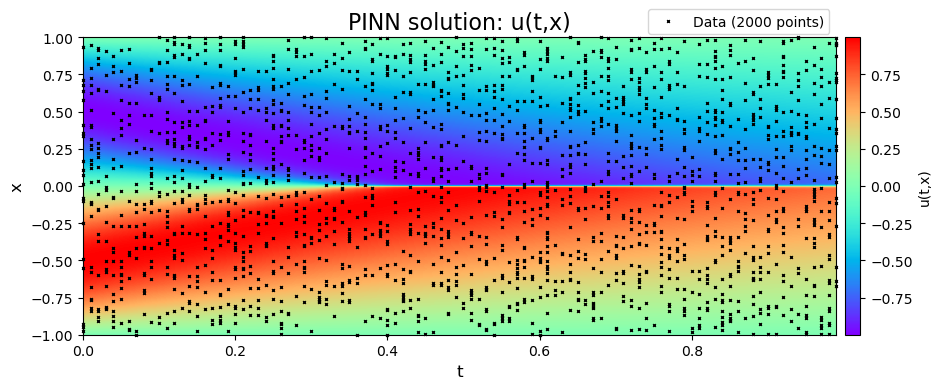

In [70]:
# Creating plot for numerical solution
fig, ax = plt.subplots(1, figsize=(10,4))
im = ax.imshow(U_pred.T,  cmap='rainbow', extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('u(t,x)')

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('PINN solution: u(t,x)', fontsize = 16)
ax.legend(loc=(0.75,1.01))
plt.tight_layout()
plt.show()

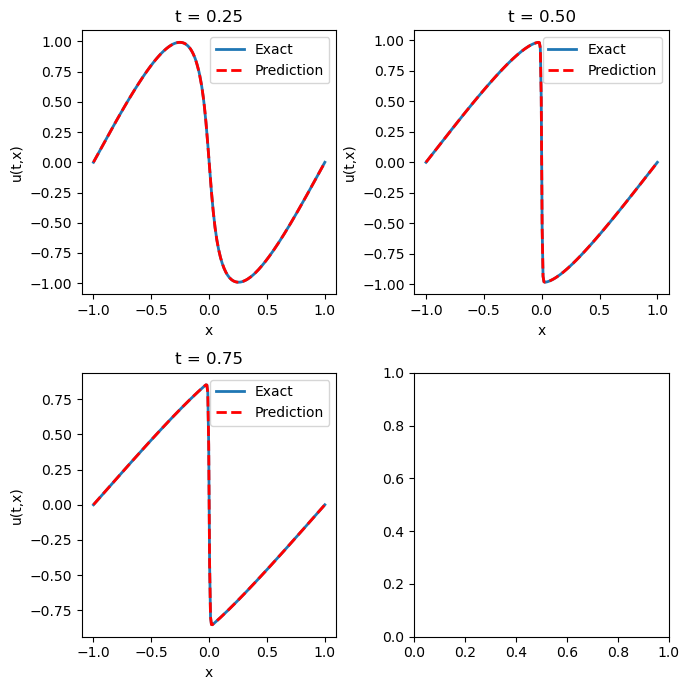

In [79]:
# Creating plot for numerical solution
fig, ax = plt.subplots(2,2, figsize=(7,7))
ax[0,0].plot(x,Exact[25,:], linewidth = 2, label = 'Exact')
ax[0,0].plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax[0,0].set(title = 't = 0.25', xlabel = 'x', ylabel = 'u(t,x)')
ax[0,1].plot(x,Exact[50,:], linewidth = 2, label = 'Exact') 
ax[0,1].plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax[0,1].set(title = 't = 0.50', xlabel = 'x', ylabel = 'u(t,x)')
ax[1,0].plot(x,Exact[75,:], linewidth = 2, label = 'Exact') 
ax[1,0].plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax[1,0].set(title = 't = 0.75', xlabel = 'x', ylabel = 'u(t,x)')
plt.tight_layout()
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
plt.show()

/var/folders/dk/lz3pdcm90wbbwyv9_l1tjq41p_gwfs/T/ipykernel_96259/215140832.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


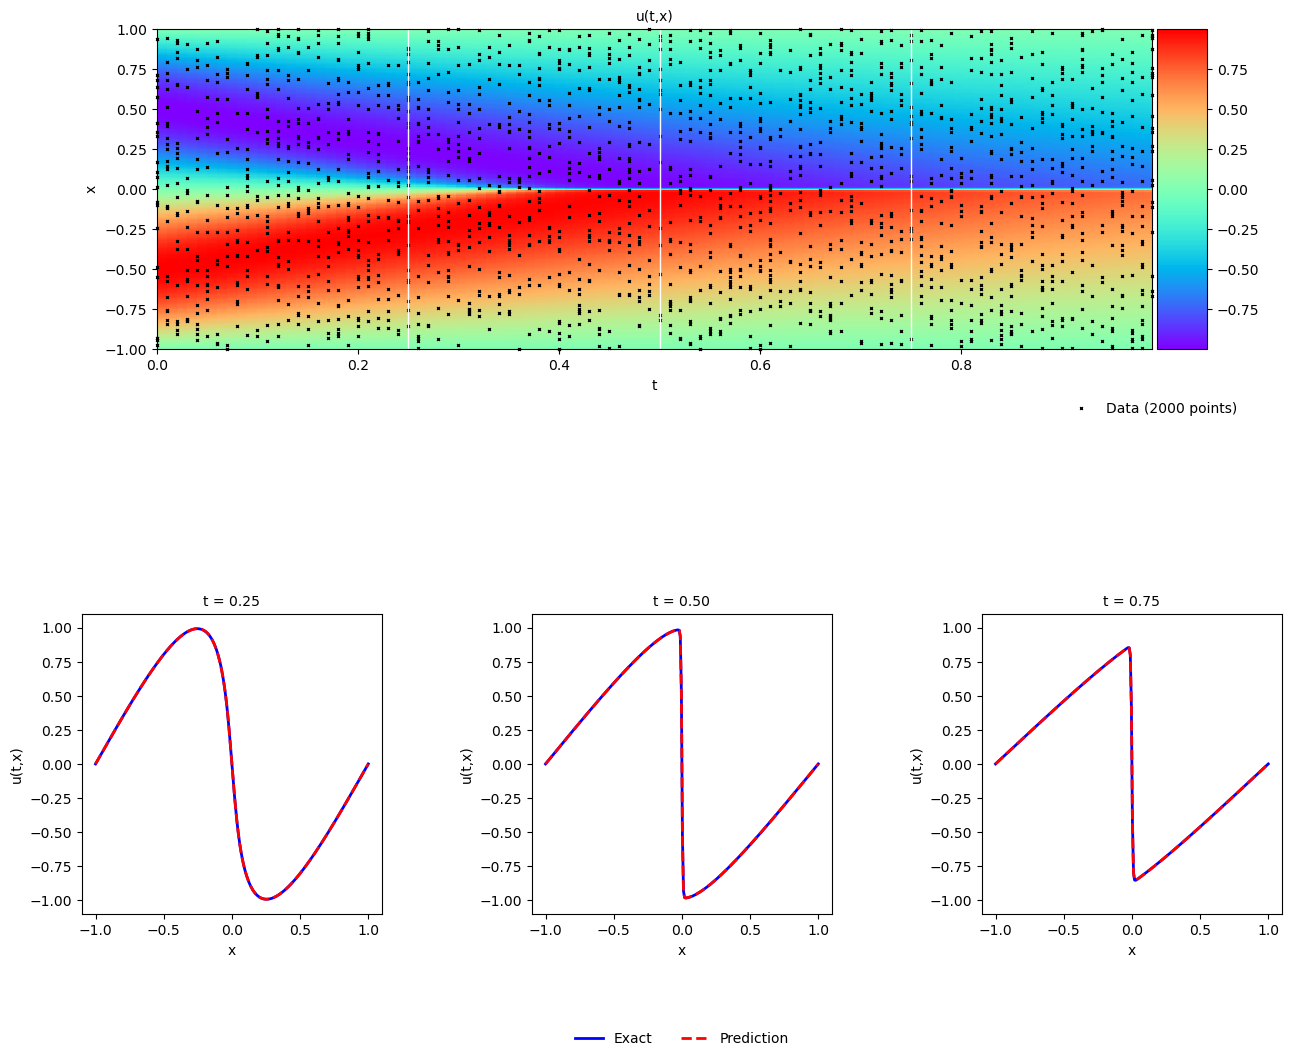

In [29]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
ax.set_title('u(t,x)', fontsize = 10)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('x')
ax.set_ylabel('u(t,x)')    
ax.set_title('t = 0.25', fontsize = 12)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('x')
ax.set_ylabel('u(t,x)')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('t = 0.50', fontsize = 12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('x')
ax.set_ylabel('u(t,x)')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('t = 0.75', fontsize = 10)

####### Row 3: Identified PDE ##################    
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1.0-2.0/3.0, bottom=0, left=0.0, right=1.0, wspace=0.0)
plt.savefig('burgens_train.pdf', bbox_inches='tight', pad_inches=0)

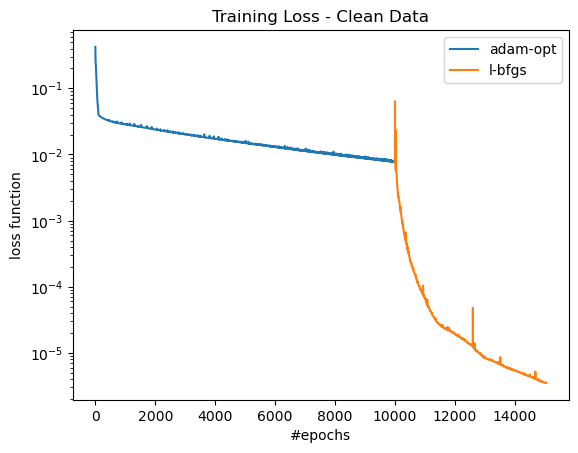

In [30]:
plt.semilogy(list(range(10000)), tr_loss[:10000], label = "adam-opt")
plt.semilogy(list(range(10000, len(tr_loss))),tr_loss[10000:], label = "l-bfgs")
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("loss function")
plt.title("Training Loss - Clean Data")
plt.show()

In [80]:
model_i = FCNI(n_input = 2, n_nodes = 20, n_hl = 9, n_output = 1, act = 'tanh')
model_i.apply(init_weights)
model_i.to(device)

opt = torch.optim.Adam(model_i.parameters(), lr = 1e-3)
iter = 0
model_i

FCNI(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [81]:
# training loop -- Adam

epochs = 10000
tr_loss = []
for epoch in tqdm(range(epochs)):
    l = tr_step(model_i, opt, x_train, u_train_noise) 
    tr_loss.append(l)
    if epoch % 10 == 0:
        print(f"Training Loss at epoch {epoch + 1}: {tr_loss[-1]:.6f}")
    if epoch % 20 == 0:
        print(f"lambda1 = {1.}     || lambda_hat_1 = {model_i.lambda_1.item():.6f}")
        print(f"lambda2 = {-0.0031831}   || lambda_hat_2 = {torch.exp(model_i.lambda_2).item():.6f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Training Loss at epoch 1: 0.380567
lambda1 = 1.0     || lambda_hat_1 = -0.000000
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 11: 0.218254
Training Loss at epoch 21: 0.191640
lambda1 = 1.0     || lambda_hat_1 = -0.000160
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 31: 0.157787
Training Loss at epoch 41: 0.117911
lambda1 = 1.0     || lambda_hat_1 = -0.000146
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 51: 0.087379
Training Loss at epoch 61: 0.068193
lambda1 = 1.0     || lambda_hat_1 = 0.000592
lambda2 = -0.0031831   || lambda_hat_2 = 0.002479
Training Loss at epoch 71: 0.056393
Training Loss at epoch 81: 0.047615
lambda1 = 1.0     || lambda_hat_1 = 0.003460
lambda2 = -0.0031831   || lambda_hat_2 = 0.002478
Training Loss at epoch 91: 0.042184
Training Loss at epoch 101: 0.039563
lambda1 = 1.0     || lambda_hat_1 = 0.005415
lambda2 = -0.0031831   || lambda_hat_2 = 0.002477
Training Loss at epoch 111: 0.0

In [82]:
tr_lbfgs(model_i, x_train, u_train_noise)

iteration: 20  loss: 0.006213
lambda1 = 1.0   || lambda_hat_1 = 0.572279
lambda2 = -0.0031831   || lambda_hat_2 = 0.002531
iteration: 40  loss: 0.004511
lambda1 = 1.0   || lambda_hat_1 = 0.672138
lambda2 = -0.0031831   || lambda_hat_2 = 0.002756
iteration: 60  loss: 0.002730
lambda1 = 1.0   || lambda_hat_1 = 0.809356
lambda2 = -0.0031831   || lambda_hat_2 = 0.003095
iteration: 80  loss: 0.001934
lambda1 = 1.0   || lambda_hat_1 = 0.855491
lambda2 = -0.0031831   || lambda_hat_2 = 0.003218
iteration: 100  loss: 0.001590
lambda1 = 1.0   || lambda_hat_1 = 0.887610
lambda2 = -0.0031831   || lambda_hat_2 = 0.003343
iteration: 120  loss: 0.001322
lambda1 = 1.0   || lambda_hat_1 = 0.918625
lambda2 = -0.0031831   || lambda_hat_2 = 0.003481
iteration: 140  loss: 0.001010
lambda1 = 1.0   || lambda_hat_1 = 0.936122
lambda2 = -0.0031831   || lambda_hat_2 = 0.003557
iteration: 160  loss: 0.000816
lambda1 = 1.0   || lambda_hat_1 = 0.955623
lambda2 = -0.0031831   || lambda_hat_2 = 0.003638
iteration: 1

In [85]:
print("Identification from Noise (1%) Data")
print(f"lambda1 = {1.}         || lambda_hat_1 = {model_i.lambda_1.item():.6f}")
print(f"lambda2 = {0.0031831}   || lambda_hat_2 = {torch.exp(model_i.lambda_2).item():.6f}")

lambda_1_value = model_i.lambda_1.item()
lambda_2_value = np.exp(model_i.lambda_2.item())


d_train = torch.unsqueeze(x_train, 0)
u_pred = model_i(d_train)
u_pred = torch.squeeze(u_pred)
u_pred = u_pred.cpu().detach().numpy()
u_train_cpu = u_train.cpu().detach().numpy()
error_u = np.linalg.norm(u_train_cpu - u_pred,2)/np.linalg.norm(u_star,2)    
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100
    
print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2)) 


mse_u = np.mean((u_pred - u_train_cpu.reshape(-1))**2)

print(f'MSE u: {mse_u}')


Identification from Noise (1%) Data
lambda1 = 1.0         || lambda_hat_1 = 0.999521
lambda2 = 0.0031831   || lambda_hat_2 = 0.003176
Error u: 1.254761e+01
Error l1: 0.04789%
Error l2: 0.20923%
MSE u: 5.327823373590945e-07


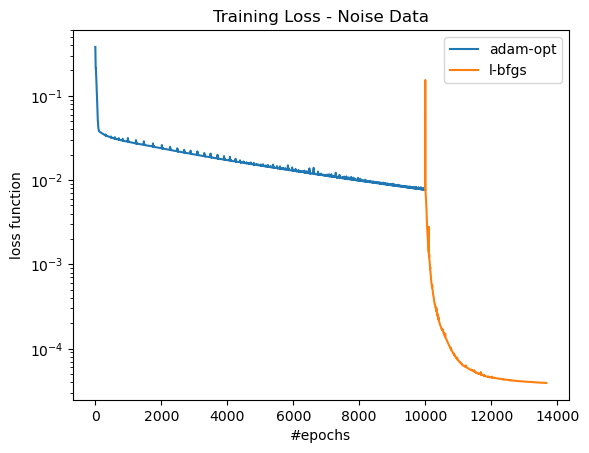

In [84]:
plt.semilogy(list(range(10000)), tr_loss[:10000], label = "adam-opt")
plt.semilogy(list(range(10000, len(tr_loss))),tr_loss[10000:], label = "l-bfgs")
plt.legend()
plt.xlabel("#epochs")
plt.ylabel("loss function")
plt.title("Training Loss - Noise Data")
plt.show()